In [1]:
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import numpy as np
import scanpy as sc
import os
from util import normalize_rows, mse, expected_sqrt, expected_log1p, poisson_log_lik
import pickle

from sklearn.utils.extmath import randomized_svd

# Downsampling Deeply Sequenced Cells

We use deeply sequenced cells from an HCA preview bone marrow dataset as a proxy for cells with known ground-truth gene distributions.

In [3]:
downsample_to = 3000
min_counts_per_gene = 500

In [4]:
data_file = '/Users/josh/src/noise2self-single-cell/data/hca/hca_marrow_deep.h5ad'
data = sc.read(data_file)

In [5]:
sc.pp.filter_genes(data, min_counts=min_counts_per_gene)
data_down = sc.pp.downsample_counts(data, downsample_to, replace = False, copy = True)

In [6]:
x = np.array(data_down.X.todense())

In [7]:
x1 = np.random.binomial(x, 0.5)
x2 = x - x1

Viewing the deeply-sequenced cells as a proxy for ground-truth, we calculate the appropriate ground-truth target for square-root normalization, the expected value of the normalized data under many draws at the same depth from the ground-truth distribution.

In [8]:
y = np.array(data.X.todense())
mean = y/y.sum(axis = 1, keepdims = True) * downsample_to/2
z = expected_sqrt(mean)

## PCA

In [9]:
def pca_sweep(x1, x2, norm=np.sqrt, z=None):
    max_k = 20

    x1_norm = norm(x1)
    x2_norm = norm(x2)

    U, S, V = randomized_svd(x1_norm, n_components=50, random_state=42)

    re_loss = []
    ss_loss = []
    if z is not None:
        gt_loss = []
    else:
        gt_loss = None
    k_range = np.arange(1, max_k)
    for k in k_range:
        x_pred = U[:,:k].dot(np.diag(S[:k])).dot(V[:k,:])
        re_loss.append(mse(x_pred, x1_norm))
        ss_loss.append(mse(x_pred, x2_norm))
        if z is not None:
            gt_loss.append(mse(x_pred, z))
    k_opt = k_range[np.argmin(ss_loss)]

    x_opt = U[:,:k_opt].dot(np.diag(S[:k_opt])).dot(V[:k_opt,:])
    print("Optimal number of PCs: ", k_opt)
    return x_opt, k_opt, re_loss, ss_loss, gt_loss, k_range

In [10]:
def quickplot(sweep_range, re_loss, ss_loss, gt_loss):
    f, (ax0, ax1, ax2) = plt.subplots(3, 1, sharex=True, figsize=(5, 10))

    ax0.plot(sweep_range, re_loss)
    ax0.set_ylabel('Reconstruction Loss')

    ax1.plot(sweep_range, ss_loss)
    ax1.set_ylabel('Self-Supervised Loss')
    ax2.plot(sweep_range, gt_loss, '--')
    ax2.set_ylabel('Ground-Truth Loss')
    ax2.set_xlabel('Principal Components')

In [11]:
_, k_opt, re_loss, ss_loss, gt_loss, k_range = pca_sweep(x1, x2, np.sqrt, z)

Optimal number of PCs:  10


In [12]:
result = {'dataset': 'hca',
          'method': 'pca',
          'loss': 'mse',
          'normalization': 'sqrt',
          'param_range': k_range,
          're_loss': re_loss,
          'ss_loss': ss_loss,
          'gt_loss': gt_loss}
pickle.dump(result, open("results/hca_pca_mse.pickle", 'wb'))

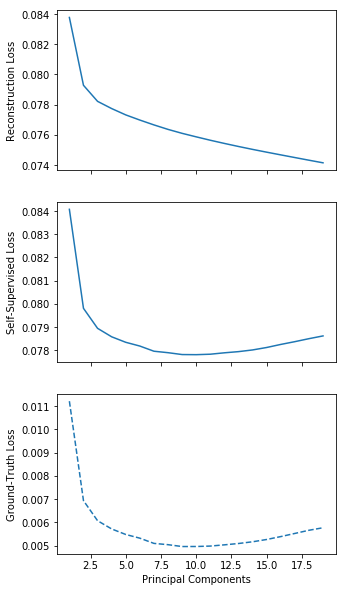

In [13]:
quickplot(k_range, re_loss, ss_loss, gt_loss)

In [14]:
# Check that we have a fixed relationship w gt loss
#np.array(ss_loss_pca_mse) - np.array(gt_loss_pca_mse)

In [15]:
print("Min GT Loss: ", np.min(gt_loss).round(4))

Min GT Loss:  0.005


# Diffusion

In [16]:
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

In [17]:
def compute_diff_op(x, lazy_p = 0):
    median_counts = np.median(x.sum(axis=1)) / 2

    X = np.sqrt(normalize_rows(x, median_counts))

    U, S, _ = randomized_svd(X, 30)
    X = U.dot(np.diag(S))
    nbrs = NearestNeighbors(n_neighbors=15).fit(X)
    diff_op = nbrs.kneighbors_graph(X, mode='connectivity')
    diff_op = np.array(diff_op.todense())
    diff_op = diff_op + diff_op.T
    diff_op = diff_op/diff_op.sum(axis = 1, keepdims = True)

    diff_op = (1 - lazy_p) * diff_op + lazy_p * np.eye(diff_op.shape[0])
    return diff_op

In [18]:
def diffusion_sweep(x1, x2, norm=np.sqrt, z=None, lazy_p = 0.25, max_t = 10, loss = mse):
    diff_op = compute_diff_op(x1, lazy_p = lazy_p)

    x1_norm = norm(x1)
    x2_norm = norm(x2)

    x_pred = x1_norm.copy().astype(np.float)

    re_loss = []
    ss_loss = []
    if z is not None:
        gt_loss = []
    else:
        gt_loss = None
        
    t_range = np.arange(max_t)
    
    for t in t_range:
        re_loss.append(loss(x_pred, x1_norm))
        ss_loss.append(loss(x_pred, x2_norm))
        if z is not None:
            gt_loss.append(loss(x_pred, z))
        x_pred = diff_op.dot(x_pred)

    t_opt = t_range[np.argmin(ss_loss)]

    x_opt = np.linalg.matrix_power(diff_op, t_opt).dot(x1_norm)
    print("Optimal diffusion time: ", t_opt)
    return x_opt, t_opt, re_loss, ss_loss, gt_loss, t_range

In [19]:
max_t = 10

In [20]:
_, t_opt, re_loss, ss_loss, gt_loss, t_range = \
    diffusion_sweep(x1, x2, np.sqrt, z)

Optimal diffusion time:  4


In [21]:
result = {'dataset': 'hca',
          'method': 'diffusion',
          'loss': 'mse',
          'normalization': 'sqrt',
          'param_range': t_range,
          're_loss': re_loss,
          'ss_loss': ss_loss,
          'gt_loss': gt_loss}
pickle.dump(result, open("results/hca_diffusion_mse.pickle", 'wb'))

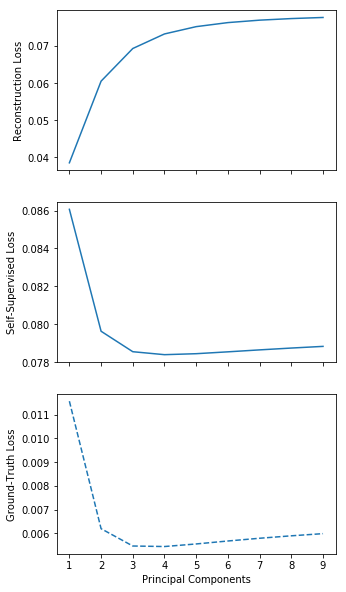

In [22]:
quickplot(t_range[1:], re_loss[1:],
          ss_loss[1:], gt_loss[1:])

In [23]:
print("Min GT Loss: ", np.min(gt_loss).round(4))

Min GT Loss:  0.0054


In [24]:
print("Min GT Loss (by SS Loss): ", np.min(gt_loss[np.argmin(ss_loss)]).round(4))

Min GT Loss (by SS Loss):  0.0054


In [25]:
_, t_opt, re_loss, ss_loss, gt_loss, t_range = \
    diffusion_sweep(x1, x2, lambda x: x, mean, max_t=10, loss=poisson_log_lik)

Optimal diffusion time:  6


In [26]:
result = {'dataset': 'hca',
          'method': 'diffusion',
          'loss': 'poisson',
          'param_range': t_range,
          're_loss': re_loss,
          'ss_loss': ss_loss,
          'gt_loss': gt_loss}
pickle.dump(result, open("results/hca_diffusion_poisson.pickle", 'wb'))

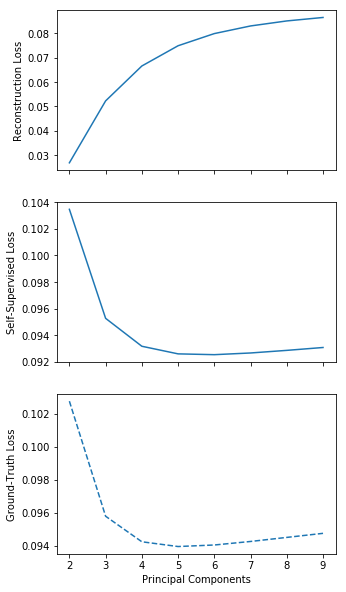

In [27]:
quickplot(t_range[2:], re_loss[2:],
          ss_loss[2:], gt_loss[2:])

## Simulation

In [28]:
with open('/Users/josh/src/noise2self-single-cell/data/sim/dataset_0.pickle', 'rb') as fp:
    exp, class_labels, programs, lib_size, umis_X, umis_Y = pickle.load(fp)
mean = np.exp(exp.dot(programs))
x1 = umis_X
x2 = umis_Y

counts = (umis_X + umis_Y).sum(axis = 1, keepdims = True)/2
mean = mean/mean.sum(axis = 1, keepdims = True) * counts
z = expected_sqrt(mean)

Optimal number of PCs:  3


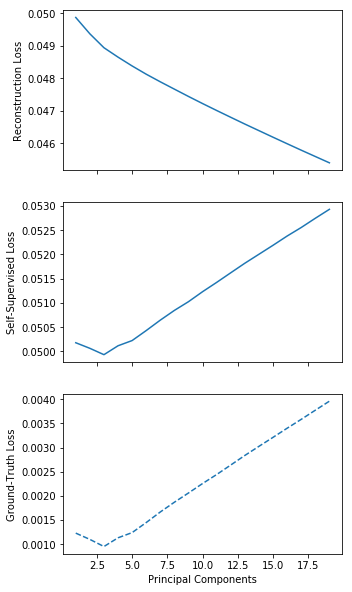

In [29]:
_, k_opt, re_loss, ss_loss, gt_loss, k_range = pca_sweep(x1, x2, np.sqrt, z)

result = {'dataset': 'sim',
          'method': 'pca',
          'loss': 'mse',
          'normalization': 'sqrt',
          'param_range': k_range,
          're_loss': re_loss,
          'ss_loss': ss_loss,
          'gt_loss': gt_loss}
pickle.dump(result, open("results/sim_pca_mse.pickle", 'wb'))

quickplot(k_range, re_loss, ss_loss, gt_loss)

### Why three PCs? That's all that can be stably recovered from the mean matrix

Text(0.5,1,'Variance Explained')

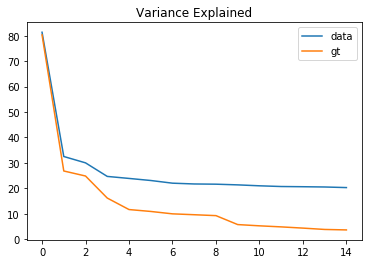

In [30]:
U, S, V = randomized_svd(np.sqrt(x1), 15)
plt.plot(S, label='data')
Uz, Sz, Vz = randomized_svd(z, 15)
plt.plot(Sz, label='gt')
plt.legend()
plt.title("Variance Explained")

Text(0.5,1,'Only the first 3 SVs are well recovered')

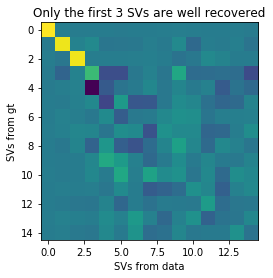

In [31]:
plt.imshow(V.dot(Vz.T))
plt.xlabel('SVs from data')
plt.ylabel('SVs from gt')
plt.title("Only the first 3 SVs are well recovered")

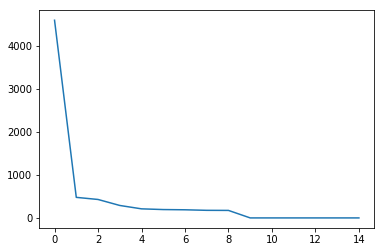

In [32]:
U, S, V = randomized_svd(np.log(mean), 15)
plt.plot(S)

Optimal diffusion time:  10


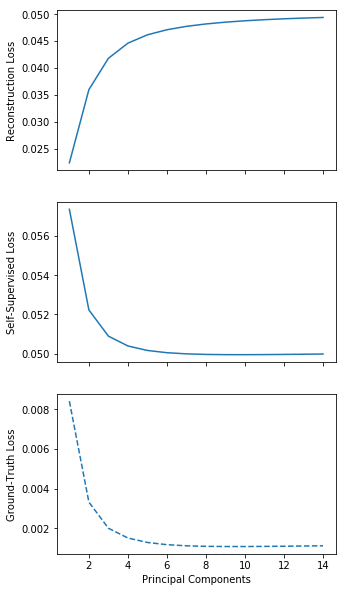

In [33]:
_, t_opt, re_loss, ss_loss, gt_loss, t_range = diffusion_sweep(x1, x2, np.sqrt, z, max_t = 15)

result = {'dataset': 'sim',
          'method': 'diffusion',
          'loss': 'mse',
          'normalization': 'sqrt',
          'param_range': t_range,
          're_loss': re_loss,
          'ss_loss': ss_loss,
          'gt_loss': gt_loss}
pickle.dump(result, open("results/sim_diffusion_mse.pickle", 'wb'))

quickplot(t_range[1:], re_loss[1:],
          ss_loss[1:], gt_loss[1:])

Optimal diffusion time:  8


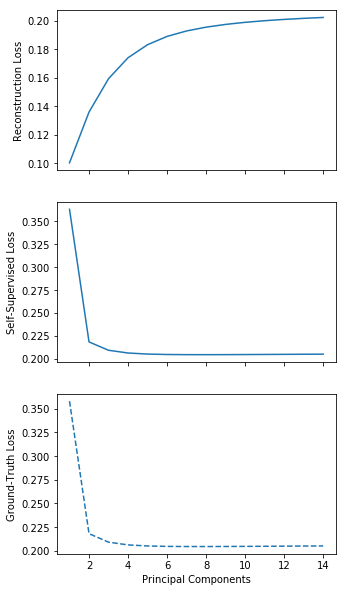

In [34]:
_, t_opt, re_loss, ss_loss, gt_loss, t_range = \
    diffusion_sweep(x1, x2, lambda x: x, mean, max_t=15, loss=poisson_log_lik)

result = {'dataset': 'sim',
          'method': 'diffusion',
          'loss': 'poisson',
          'param_range': t_range,
          're_loss': re_loss,
          'ss_loss': ss_loss,
          'gt_loss': gt_loss}
pickle.dump(result, open("results/sim_diffusion_poisson.pickle", 'wb'))

quickplot(t_range[1:], re_loss[1:],
          ss_loss[1:], gt_loss[1:])